## Hoja de trabajo 2 - Minería de Datos

Hecho por Diego Morales y Alejandro Azurdia
08/02/2023

In [136]:
# Importar librerías Generales
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import locale
from scipy.stats import anderson
import statsmodels.api as sm
from ydata_profiling import ProfileReport

%matplotlib inline

In [137]:
from datetime import datetime

# Función para convertir el formato de 12 horas a 24 horas
def convert_to_24h(time_str):
    # Eliminar "Start Time:" y "Local" del string
    time_str_cleaned = time_str.replace("Start Time: ", "").replace("Local", "").strip()
    # Reemplazar posibles variantes de p.m. y a.m.
    time_str_cleaned = time_str_cleaned.replace("p.m.", "").replace("a.m.", "")
    
    time_str_cleaned = time_str_cleaned.replace(" ", "")
 
    # Convertir a formato de 24 horas
    time_obj = datetime.strptime(time_str_cleaned, "%I:%M")
    return time_obj.strftime("%H:%M")

# funcion para convertir attendance si viene en este formato: 40,030'] a 40030
def convert_attendance(attendance_str):
    try:
        return int(attendance_str.replace(",", "").replace("']", ""))
    except:
        # se borra la fila si no se puede convertir
        return np.nan


In [138]:
# Convertir la columna 'date' al formato yyyy/mm/dd si viene en el formato: 'Monday, April 4, 2016'
def convert_date_to_yyyy_mm_dd(date_str):
    # Cambiar la localización a inglés
    locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
    date_object = datetime.strptime(date_str, '%A, %B %d, %Y')
    return date_object

In [139]:
# Convertir la columan 'duration' a minutos si viene en el formato: ': 1:30'
def convert_duration_to_minutes(duration_str):
    try:
        duration_str = duration_str.replace(": ", "")
        duration_str = duration_str.split(":")
        return int(duration_str[0])*60 + int(duration_str[1])
    except:
        pass


## Haga una exploración rápida de sus datos para ello, haga un resumen del conjunto de datos.

In [140]:
locale.setlocale( locale.LC_ALL, '' )

"""
esperando numeros: away_team_errors, away_team_hits, away_team_runs, game_duration, home_team_errors, home_team_hits, home_team_runs, 
quitar ': ' a venue
date-> date
time: start_time
"""

# Lectura de datos
df = pd.read_csv('baseball_reference_2016_scrape.csv')

# Aplicar la función a la columna 'start_time'
df['start_time'] = df['start_time'].apply(convert_to_24h)

# Convertir la columna 'date' al formato yyyy/mm/dd si viene en el formato: 'Monday, April 4, 2016'
df['date'] = df['date'].apply(convert_date_to_yyyy_mm_dd)

# Convertir la columan 'duration' a minutos si viene en el formato: ':1:30'
df['game_duration'] = df['game_duration'].apply(convert_duration_to_minutes)

df['attendance'] = df['attendance'].apply(convert_attendance)

# borrar las columnas con NaN en la columna 'attendance'
df = df.dropna(subset=['attendance'])


list_nums = ['away_team_errors', 'away_team_hits', 'away_team_runs', 'home_team_errors', 'home_team_hits', 'home_team_runs']
# si en la columna dada no se puede convertir en número, se borra la fila. 
for col in list_nums:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=[col])

df.head()

,attendance,away_team,away_team_errors,away_team_hits,away_team_runs,boxscore_url,date,field_type,game_duration,game_type,home_team,home_team_errors,home_team_hits,home_team_runs,other_info_string,start_time,venue
0,40030.0,New York Mets,1,7,3,https://www.baseball-reference.com/boxes/KCA/K...,2016-04-03,NaN,193.0,"Night Game, on grass",Kansas City Royals,0,9,4,"<!-- \n <div class=""section_content"" id=""d...",07:38,: Kauffman Stadium
1,21621.0,Philadelphia Phillies,0,5,2,https://www.baseball-reference.com/boxes/CIN/C...,2016-04-06,NaN,143.0,"Night Game, on grass",Cincinnati Reds,0,8,3,"<!-- \n <div class=""section_content"" id=""d...",07:11,: Great American Ball Park
2,12622.0,Minnesota Twins,0,5,2,https://www.baseball-reference.com/boxes/BAL/B...,2016-04-06,NaN,191.0,"Night Game, on grass",Baltimore Orioles,0,9,4,"<!-- \n <div class=""section_content"" id=""d...",07:07,: Oriole Park at Camden Yards
3,18531.0,Washington Nationals,0,8,3,https://www.baseball-reference.com/boxes/ATL/A...,2016-04-06,NaN,173.0,"Night Game, on grass",Atlanta Braves,1,8,1,"<!-- \n <div class=""section_content"" id=""d...",07:10,: Turner Field
4,18572.0,Colorado Rockies,1,8,4,https://www.baseball-reference.com/boxes/ARI/A...,2016-04-06,NaN,159.0,"Day Game, on grass",Arizona Diamondbacks,0,8,3,"<!-- \n <div class=""section_content"" id=""d...",00:40,: Chase Field


In [141]:
# profile = ProfileReport(df, title="Profiling Report")
# profile

In [142]:
df = df.drop(['boxscore_url', 'field_type', 'other_info_string'], axis=1)
# drop where index of row is 902	
df = df.drop(223)
df = df.drop(1727)
df = df.drop(1915)
df.head()

,attendance,away_team,away_team_errors,away_team_hits,away_team_runs,date,game_duration,game_type,home_team,home_team_errors,home_team_hits,home_team_runs,start_time,venue
0,40030.0,New York Mets,1,7,3,2016-04-03,193.0,"Night Game, on grass",Kansas City Royals,0,9,4,07:38,: Kauffman Stadium
1,21621.0,Philadelphia Phillies,0,5,2,2016-04-06,143.0,"Night Game, on grass",Cincinnati Reds,0,8,3,07:11,: Great American Ball Park
2,12622.0,Minnesota Twins,0,5,2,2016-04-06,191.0,"Night Game, on grass",Baltimore Orioles,0,9,4,07:07,: Oriole Park at Camden Yards
3,18531.0,Washington Nationals,0,8,3,2016-04-06,173.0,"Night Game, on grass",Atlanta Braves,1,8,1,07:10,: Turner Field
4,18572.0,Colorado Rockies,1,8,4,2016-04-06,159.0,"Day Game, on grass",Arizona Diamondbacks,0,8,3,00:40,: Chase Field


In [143]:
import pandas as pd

def find_non_numeric_rows(df, columns):
    """
    Muestra las filas del DataFrame donde alguna de las columnas especificadas tiene un valor no numérico.
    
    Parámetros:
    - df: DataFrame de pandas.
    - columns: Lista de columnas para verificar los valores no numéricos.
    
    Retorna:
    - Un DataFrame con las filas que contienen valores no numéricos en las columnas especificadas.
    """
    non_numeric_rows = pd.DataFrame()
    
    for col in columns:
        # Intenta convertir la columna a numérico, marcando valores no numéricos como NaN
        temp = pd.to_numeric(df[col], errors='coerce')
        
        # Encuentra filas donde la conversión falló (valores originales no numéricos)
        non_numeric_mask = temp.isna() & df[col].notna()
        
        # Añade las filas encontradas al DataFrame de resultados
        non_numeric_rows = non_numeric_rows._append(df[non_numeric_mask])
    
    # Elimina posibles duplicados en el caso de que una fila tenga más de un valor no numérico en columnas diferentes
    non_numeric_rows = non_numeric_rows.drop_duplicates()
    
    return non_numeric_rows

list_nums = ['away_team_errors', 'away_team_hits', 'away_team_runs', 'home_team_errors', 'home_team_hits', 'home_team_runs']

# Llama a la función
non_numeric_rows = find_non_numeric_rows(df, list_nums)
non_numeric_rows

,attendance,away_team,away_team_errors,away_team_hits,away_team_runs,date,game_duration,game_type,home_team,home_team_errors,home_team_hits,home_team_runs,start_time,venue


In [156]:
df.columns

Index(['attendance', 'away_team', 'away_team_errors', 'away_team_hits',
       'away_team_runs', 'date', 'game_duration', 'game_type', 'home_team',
       'home_team_errors', 'home_team_hits', 'home_team_runs', 'start_time',
       'venue'],
      dtype='object')

# Regresión Lineal

R^2: 0.7402540830175144


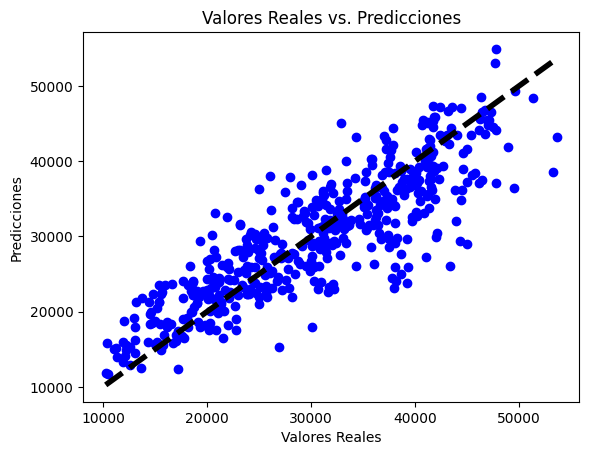

In [144]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Separar los datos y es attendance, x es todo lo demás. 
x = df.drop('attendance', axis=1)
y = df['attendance']

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# transformar todas las columnas categóricas a one-hot encoding

# Columnas categóricas
categorical_columns = ['away_team', 'date', 'game_type', 'home_team', 'start_time', 'venue']

# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), categorical_columns)
    ])

x = preprocessor.fit_transform(x)

# Dividir los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Crear un modelo de regresión lineal
model = LinearRegression()
model.fit(x_train, y_train)

# Calcular y mostrar el R^2
y_pred = model.predict(x_test)

r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")

# Graficar los datos
plt.scatter(y_test, y_pred, color='blue')
plt.title('Valores Reales vs. Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4) # Línea de perfecta predicción
plt.show()

### Obtener las constantes del modelo y expresar la ecuación que represnta. 

In [145]:
# Obtener el intercepto
intercept = model.intercept_

# Obtener los coeficientes
coefficients = model.coef_

# La ecuación sería algo como:
# y = intercept + coef_1*x_1 + coef_2*x_2 + ... + coef_n*x_n
string_ecuación = ""
for i, coef in enumerate(coefficients):
    string_ecuación += f" + {coef}x_{i}"
string_ecuación = f"{intercept}{string_ecuación}"
print(f"Ecuación: y = {string_ecuación}")


# Expresar la ecuación
print(f"Intercept: {intercept}")
print("Coefficients:")
for i, coef in enumerate(coefficients):
    print(f"  Coeficiente para la variable {i}: {coef}")

Ecuación: y = 31114.838155206722 + -262.4370740796434x_0 + -1831.148953701257x_1 + 148.0204584849199x_2 + 2355.726347418191x_3 + 5430.424864192024x_4 + -772.5204890387388x_5 + -375.0200493669702x_6 + -2523.3511597903525x_7 + -1106.9728033774863x_8 + 385.95804330746756x_9 + -1261.7220829942717x_10 + 211.5194031395869x_11 + 53.01073866342809x_12 + 1470.2346537571325x_13 + -358.83134947348356x_14 + -114.35825657009683x_15 + -1782.768908955184x_16 + 686.8604983445391x_17 + 2463.4861012809147x_18 + -1493.6882706769222x_19 + 701.3115471234621x_20 + -905.9256885485078x_21 + -564.9073169596348x_22 + 1071.614573097118x_23 + -902.9350688142245x_24 + 1110.3915482943924x_25 + -1672.8594708549024x_26 + -2490.169150589284x_27 + 1694.220523847377x_28 + 636.8367928401336x_29 + 10094.31135393767x_30 + 11995.450491101847x_31 + -62.14452552307807x_32 + -6217.3793735509125x_33 + -4282.532937430227x_34 + 1837.043223516563x_35 + 1136.457947081569x_36 + -596.1940664807234x_37 + -3278.0896073022786x_38 + -829

In [158]:
df.head(3)

,attendance,away_team,away_team_errors,away_team_hits,away_team_runs,date,game_duration,game_type,home_team,home_team_errors,home_team_hits,home_team_runs,start_time,venue
0,40030.0,New York Mets,1,7,3,2016-04-03,193.0,"Night Game, on grass",Kansas City Royals,0,9,4,07:38,: Kauffman Stadium
1,21621.0,Philadelphia Phillies,0,5,2,2016-04-06,143.0,"Night Game, on grass",Cincinnati Reds,0,8,3,07:11,: Great American Ball Park
2,12622.0,Minnesota Twins,0,5,2,2016-04-06,191.0,"Night Game, on grass",Baltimore Orioles,0,9,4,07:07,: Oriole Park at Camden Yards


In [ ]:
data_pred_dic = {
    'away_team': 'Houston Astros',
    'home_team': 'New York Yankees',
    'venue': 'Yankee Stadium III'
}

input_data = pd.DataFrame(data_pred_dic, index=[0])

input_processed = preprocessor.transform(input_data)


# Regresión Lineal Multiple

In [146]:
# X = todas las columnas menos 'attendance'
X_LM = df.drop('attendance', axis=1)
# y = columna 'attendance'
y_LM = df['attendance']

In [147]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# transformar todas las columnas categóricas a one-hot encoding

# Columnas categóricas
categorical_columns = ['away_team', 'date', 'game_type', 'home_team', 'start_time', 'venue']

# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), categorical_columns)
    ])

# Aplicar el preprocesador a las columnas
X_LM = preprocessor.fit_transform(X_LM)

In [148]:
from sklearn.model_selection import train_test_split
X_entreno, X_prueba, y_entreno, y_prueba = train_test_split(X_LM, y_LM, test_size = 0.2, random_state = 0)

In [149]:
from sklearn.linear_model import LinearRegression
regresor = LinearRegression()
regresor.fit(X_entreno, y_entreno)

LinearRegression()

In [150]:
"""
y_pred = regresor.predict(X_prueba)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_prueba.reshape(len(y_prueba),1)),1))
"""

'\ny_pred = regresor.predict(X_prueba)\nnp.set_printoptions(precision=2)\nprint(np.concatenate((y_pred.reshape(len(y_pred),1), y_prueba.reshape(len(y_prueba),1)),1))\n'

# Regresión Lineal Polinomial 

R^2: 0.7819679591198774


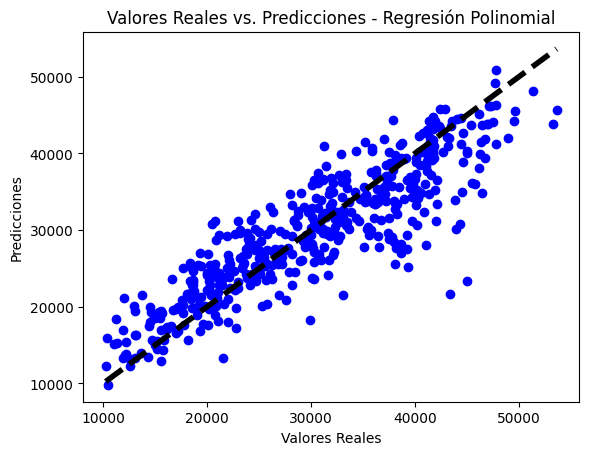

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

x = df.drop('attendance', axis=1)
y = df['attendance']

# Columnas categóricas
categorical_columns = ['away_team', 'date', 'game_type', 'home_team', 'start_time', 'venue']

# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), categorical_columns)
    ])

# Aplicar el preprocesador a las columnas
x = preprocessor.fit_transform(x)

# Dividir los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Crear características polinomiales
degree = 2  # Define el grado del polinomio
poly_features = PolynomialFeatures(degree=degree)
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.transform(x_test)

# Crear y entrenar el modelo de regresión lineal con características polinomiales
model = LinearRegression()
model.fit(x_train_poly, y_train)

# Predicciones
y_pred = model.predict(x_test_poly)

# Calcular y mostrar el R^2
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")

# Graficar los valores reales vs. las predicciones
plt.scatter(y_test, y_pred, color='blue')
plt.title('Valores Reales vs. Predicciones - Regresión Polinomial')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.show()

### Obtener las constantes del modelo y expresar la ecuación

In [154]:
# Obtener el intercepto
intercept = model.intercept_

# Obtener los coeficientes
coefficients = model.coef_

# La ecuación sería algo como:
# y = intercept + coef_1*x_1 + coef_2*x_2 + ... + coef_n*x_n
string_ecuación = ""
for i, coef in enumerate(coefficients):
    string_ecuación += f" + {coef}x_{i}"
string_ecuación = f"{intercept}{string_ecuación}"
print(f"Ecuación: y = {string_ecuación}")

Ecuación: y = 31325.638152938973 + 2.3620796423295858e-11x_0 + -11.73608869522861x_1 + -679.0811394941951x_2 + 112.43420827669406x_3 + 1260.0614766428052x_4 + 2090.4980678503025x_5 + -320.20735401473473x_6 + -169.83535130025209x_7 + -684.4234452016306x_8 + -580.1838885455011x_9 + 438.59931420403467x_10 + -330.53298835767345x_11 + -27.004576829137157x_12 + -79.01107765574082x_13 + 688.0474697445408x_14 + -318.9024329721809x_15 + -286.11094505936694x_16 + -932.8372025140494x_17 + 8.835407410712525x_18 + 1059.5381901867188x_19 + -527.6281028325511x_20 + 110.59337753422649x_21 + -453.3012571888572x_22 + -187.49216774257x_23 + 726.7986927073844x_24 + -396.2586919298931x_25 + 342.95090408467695x_26 + -689.373217715173x_27 + -936.9500289178778x_28 + 536.2937565946094x_29 + 236.21909172988256x_30 + 1714.1348321367602x_31 + 3897.8590065145236x_32 + 160.96884843702512x_33 + -2072.68597946222x_34 + -1080.2141910079733x_35 + 1956.6445596481835x_36 + 615.5200839656104x_37 + 59.063315381310964x_38 +

# Support Vector Regression SVR

# Árboles de Desición

R^2: 0.5820463539540037


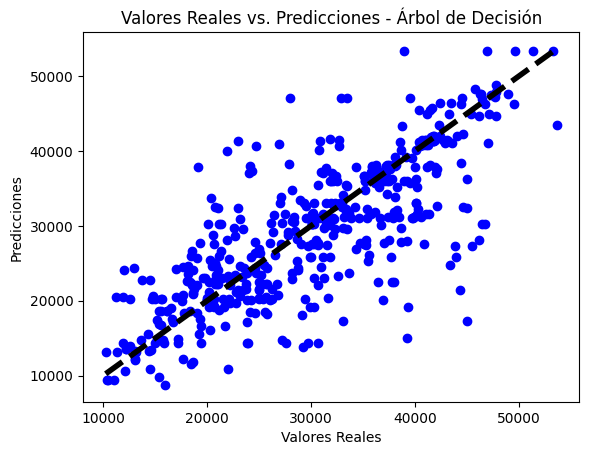

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que df está definido como antes

x = df.drop('attendance', axis=1)
y = df['attendance']

# Columnas categóricas
categorical_columns = ['away_team', 'date', 'game_type', 'home_team', 'start_time', 'venue']

# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), categorical_columns)
    ])

# Aplicar el preprocesador a las columnas
x = preprocessor.fit_transform(x)

# Dividir los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de árbol de decisión
model = DecisionTreeRegressor(random_state=42)
model.fit(x_train, y_train)

# Predicciones
y_pred = model.predict(x_test)

# Calcular y mostrar el R^2
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")

# Graficar los valores reales vs. las predicciones
plt.scatter(y_test, y_pred, color='blue')
plt.title('Valores Reales vs. Predicciones - Árbol de Decisión')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.show()

# Random Forest

R^2: 0.7517377064467256


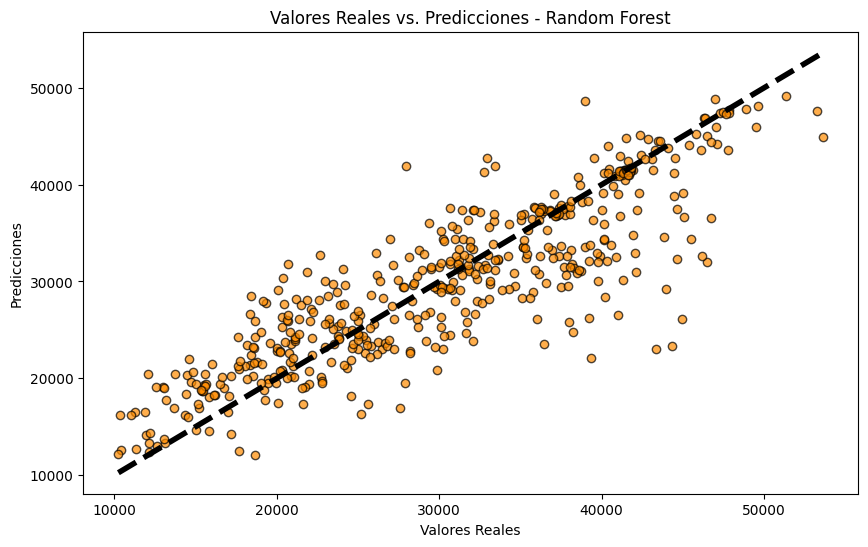

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que df está definido como antes

x = df.drop('attendance', axis=1)
y = df['attendance']

# Columnas categóricas
categorical_columns = ['away_team', 'date', 'game_type', 'home_team', 'start_time', 'venue']

# Crear un objeto ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), categorical_columns)
    ])

# Aplicar el preprocesador a las columnas
x = preprocessor.fit_transform(x)

# Dividir los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

# Predicciones
y_pred = model.predict(x_test)

# Calcular y mostrar el R^2
r2 = r2_score(y_test, y_pred)
print(f"R^2: {r2}")

# Graficar los valores reales vs. las predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='darkorange', edgecolor='black', alpha=0.7)
plt.title('Valores Reales vs. Predicciones - Random Forest')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Línea de perfecta predicción
plt.show()


Después de depurar nuestro conjunto de datos usando diversas técnicas, pero sobre todo apoyandonos con el profiler, hemos entrenado todos los modelos vistos hasta ahora. 

Apoyandonos con el parámetro r2, hemos encontrado que el mejor modelo es **Nombre Del Modelo**. 
